In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import math
from IPython.display import display, HTML

In [7]:
class FCT:

    def __init__(self, folder, toponame, flownum, loads, algs):
        self.flownum = flownum
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                alg = algs[alg_i]
                load = loads[load_i]
                print("tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                self.raw_data[alg_i][load_i] = \
                    self.parse_trace(folder, filename="tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                    
    # At least two
    def plotting_mean_FCT(self):
        plt.figure(figsize=(8,5))
        plt.xlabel("Link utilization")
        plt.ylabel("Normalized FCT")
        plt.title("Normalized FCT")
        for alg_i in range(len(self.algs)):
            alg = self.algs[alg_i]
            load_means = [0 for i in range(len(self.loads))]
            for load_i in range(len(self.loads)):
                load = self.loads[load_i]
                load_means[load_i] = self.raw_data[alg_i][load_i]["Normalized FCT"].mean()
            plt.plot(self.loads, load_means, label=alg)
        plt.legend(loc='best')
        plt.show()
    
    # Normalized FCT = Actual FCT / min FCT
    # min FCT = flow_size / max bandwidth
    def parse_trace(self, dir, filename):
        col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
                   "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
        df = pd.read_csv(dir+filename, sep = ' ', header = None)
        df.columns = col
        df["Normalized FCT"] = 40 * 1e9 / df["Average rate"]
        return df
    
    def get_load_id(self, load):
        return self.loads.index(load)
    
    def get_alg_id(self, alg):
        return self.algs.index(alg)
    
    def humanbytes(self, B):
        B = float(B)
        KB = float(1000)
        MB = float(KB ** 2)
        GB = float(KB ** 3)
        TB = float(KB ** 4) 

        if B < KB:
            return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
        elif KB <= B < MB:
            return '{0:.2f} KB'.format(B/KB)
        elif MB <= B < GB:
            return '{0:.2f} MB'.format(B/MB)
        elif GB <= B < TB:
            return '{0:.2f} GB'.format(B/GB)
        elif TB <= B:
            return '{0:.2f} TB'.format(B/TB)
        
    def plot_FCT_flowsize(self, alg, load, color=None, scale=[0,0], label=None):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df=self.raw_data[alg_id][load_id]
        y = df['Normalized FCT'].apply(self.scaling, args=(scale[1],))
        x = df['tmp_pkts'].apply(self.scaling, args=(scale[0],))
        plt.scatter(x, y, color=color, label=label)
        plt.xlabel('flow size')
        plt.ylabel('Normalized FCT')
        plt.legend()
        plt.show()
        
    def scaling(self, x, base):
        return x if (base == 0 or x<base) else base + x / base
    
    def plot_one_FCT_percentile(self, alg, load, percentile, flow_size, scale=[0,0], isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            print(label)
            display(seg_data)
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * 0.95), 16])
            corresponding_flow_size.append(label)
        #scaled_selected_flow = [self.scaling(x, scale[0]) for x in selected_flow]
        #scaled_flow_size = [self.scaling(x, scale[1]) for x in corresponding_flow_size]
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.grid()
            plt.legend()
            #plt.yticks([0,50,100,150,200])
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()
            
    def plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size, scale=[0,0]):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, True)
            else:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, False)

tcp_DropTail_flow_10_0.5_Topology-incast-singlenode-small.tcl.tr
0


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
6,6.0,0.000051,10,0,0,1,0,3,1,1,0.0,0.0,0,1.362809e+09,1.007847,29.351142


13


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
4,16.0,0.000077,14,0,0,0,0,3,1,1,0.0,0.0,0,2.437421e+09,1.007396,16.410788
7,19.0,0.000078,22,0,0,1,0,3,1,1,0.0,0.0,0,2.860856e+09,1.010938,13.981831


19


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
5,23.0,0.000081,16,0,0,0,0,3,1,1,0.0,0.0,0,3.332161e+09,1.007448,12.004221


33


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
0,48.0,0.000094,7,0,0,1,1,3,1,1,0.0,0.0,0,5.939285e+09,1.005595,6.734817
1,47.0,0.000094,6,0,0,1,0,3,1,1,0.0,0.0,0,5.834091e+09,1.005687,6.856252
2,45.0,0.000093,5,0,0,0,1,3,1,1,0.0,0.0,0,5.621679e+09,1.005782,7.115312
3,44.0,0.000093,4,0,0,0,0,3,1,1,0.0,0.0,0,5.514447e+09,1.005878,7.253674
8,40.0,0.000092,18,0,0,0,0,3,1,1,0.0,0.0,0,5.078526e+09,1.012439,7.876301
9,37.0,0.000091,12,0,0,0,1,3,1,1,0.0,0.0,0,4.744048e+09,1.013825,8.431618


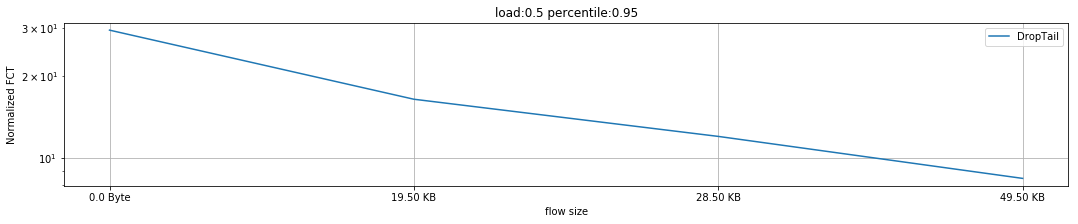

tcp_DropTail_flow_10_0.5_Topology-incast-singlenode.tcl.tr
6


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
3,10.0,0.000116,18,0,0,1,0,3,1,1,0.0,0.0,0,1.011070e+09,1.007847,39.562055


33


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
1,47.0,0.000146,8,0,0,0,0,3,1,1,0.0,0.0,0,3.758193e+09,1.007396,10.643413


53


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
6,120.0,0.000342,20,0,0,1,0,3,1,1,0.0,0.0,0,4.097500e+09,1.010938,9.762049


133


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
2,406.0,0.000252,10,0,0,0,0,3,1,1,0.0,0.0,0,1.884559e+10,1.007448,2.122513


1333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
8,2566.0,0.000853,14,0,0,0,0,3,1,1,0.0,0.0,0,3.513094e+10,1.012439,1.138597
9,1998.0,0.000683,28,0,0,0,1,3,1,1,0.0,0.0,0,3.418190e+10,1.013825,1.170210


3333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
0,5326.0,0.001856,7,0,0,1,1,3,1,1,0.0,0.0,0,3.352127e+10,1.005595,1.193272
4,3750.0,0.005106,4,0,0,0,0,3,1,1,0.0,0.0,0,8.577521e+09,1.005878,4.663352
5,4801.0,0.005429,6,0,0,1,0,3,1,1,0.0,0.0,0,1.032985e+10,1.005687,3.872273
7,4276.0,0.005534,5,0,0,0,1,3,1,1,0.0,0.0,0,9.024471e+09,1.005782,4.432393


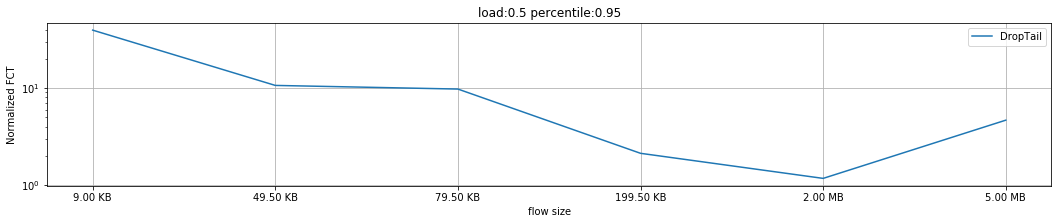

tcp_DropTail_flow_10_0.5_Topology-incast-singlenode-big.tcl.tr
133


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
2,607.0,0.005088,12,0,0,1,0,3,1,1,0.0,0.0,0,1.393348e+09,1.007847,28.707833


1333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
1,3217.0,0.001912,14,0,0,1,0,3,1,1,0.0,0.0,0,1.964732e+10,1.010938,2.035901
3,2226.0,0.008292,8,0,0,0,0,3,1,1,0.0,0.0,0,3.135506e+09,1.007396,12.757111


3333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
4,4185.0,0.01181,10,0,0,0,0,3,1,1,0.0,0.0,0,4.138906e+09,1.007448,9.66439


6667


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
0,16123.0,0.005577,7,0,0,1,1,3,1,1,0.0,0.0,0,3.376828e+10,1.005595,1.184543
5,8882.0,0.012546,24,0,0,0,1,3,1,1,0.0,0.0,0,8.268670e+09,1.013825,4.837537
6,10776.0,0.018137,18,0,0,0,0,3,1,1,0.0,0.0,0,6.939462e+09,1.012439,5.764136
7,13917.0,0.026316,4,0,0,0,0,3,1,1,0.0,0.0,0,6.176914e+09,1.005878,6.475726
8,14653.0,0.026878,5,0,0,0,1,3,1,1,0.0,0.0,0,6.367610e+09,1.005782,6.281792
9,15388.0,0.026985,6,0,0,1,0,3,1,1,0.0,0.0,0,6.660425e+09,1.005687,6.005623


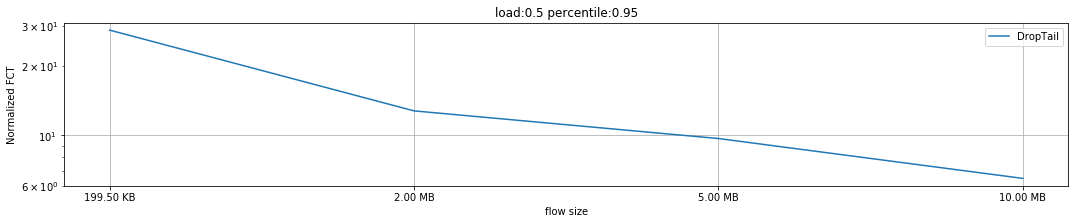

In [8]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    # print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    algs=["DropTail"]

    
    FCT_analysis_small = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-small.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_small.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)
    
    
    FCT_analysis_normal = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_normal.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)        
    
    
    FCT_analysis_big = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-big.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_big.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)    

['0.0 Byte', '8.79 KB', '19.04 KB', '27.83 KB', '48.34 KB', '77.64 KB', '194.82 KB', '1.91 MB', '4.77 MB', '9.54 MB', 'inf TB']


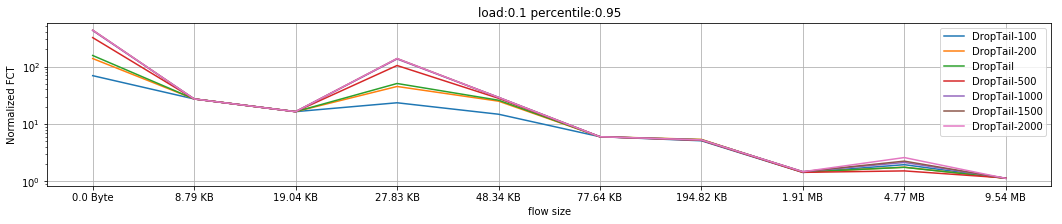

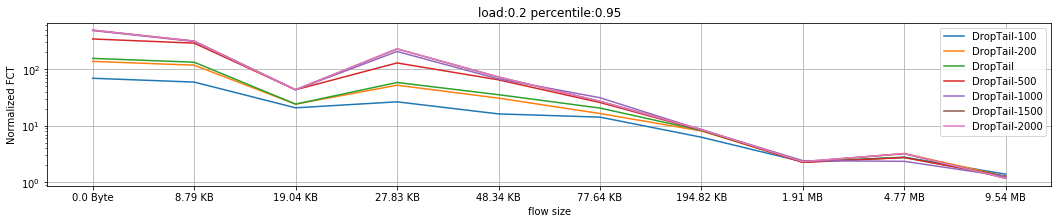

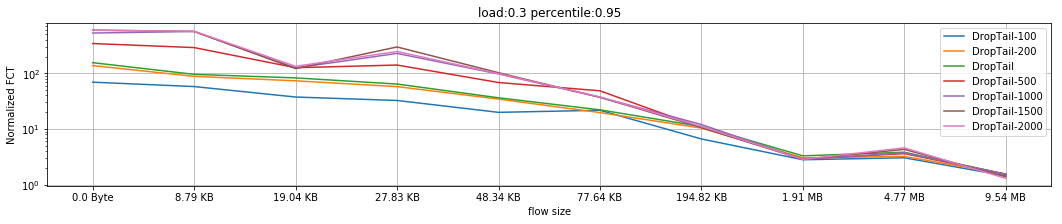

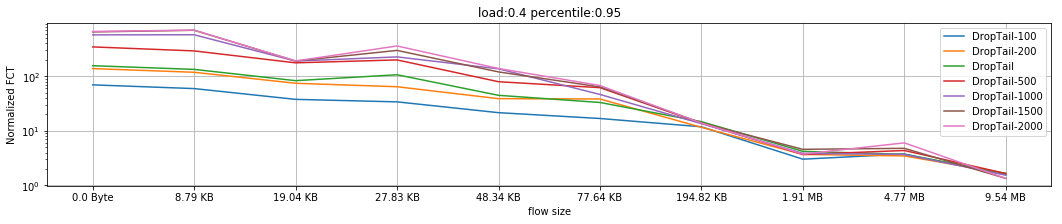

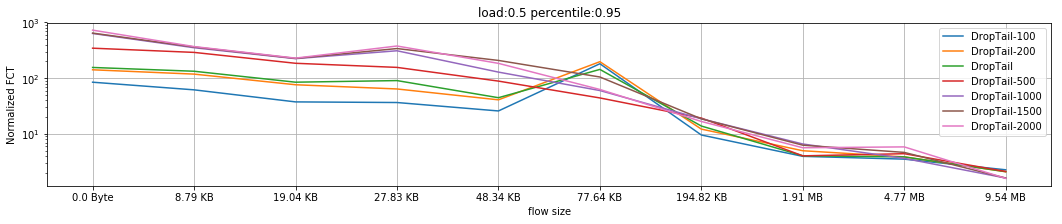

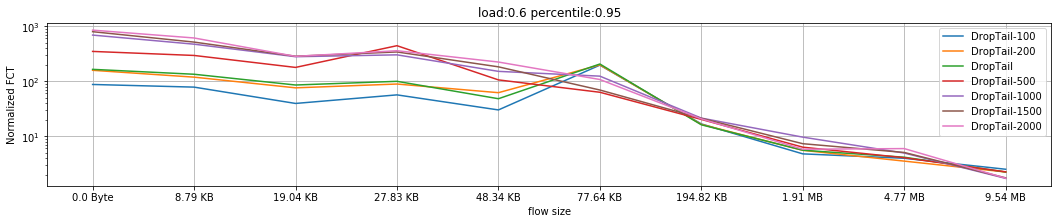

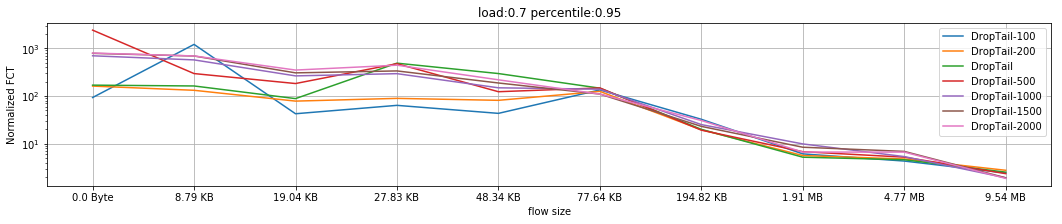

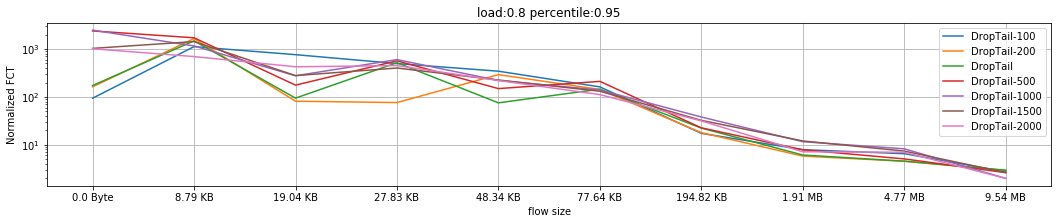

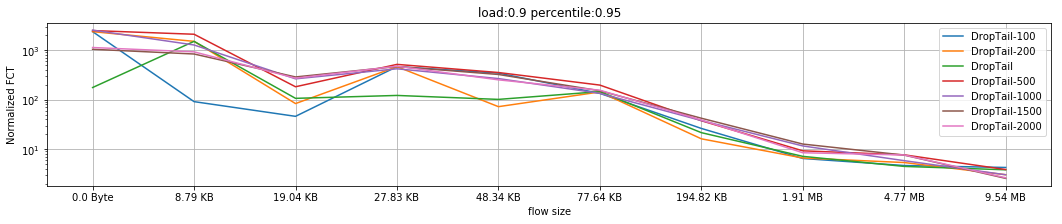

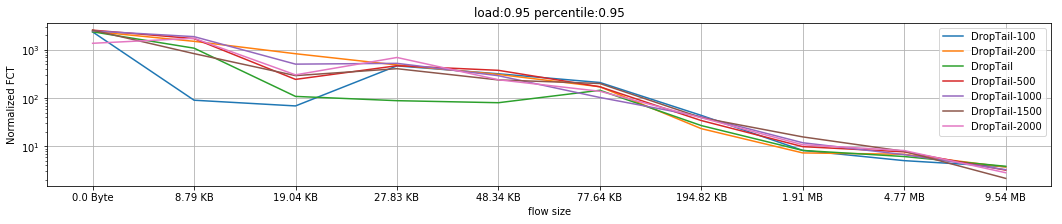

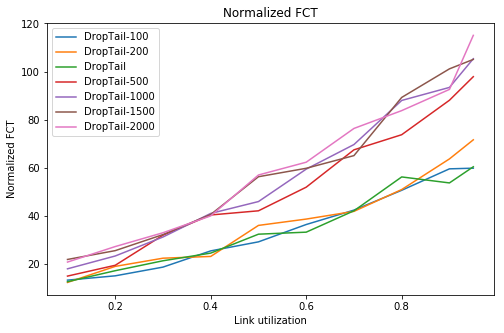

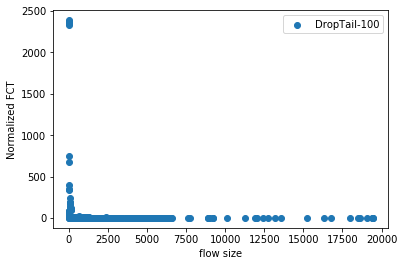

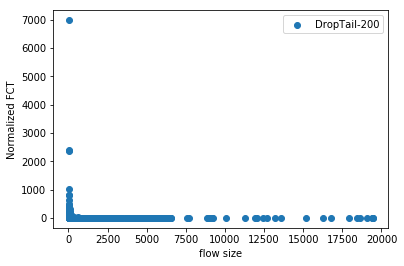

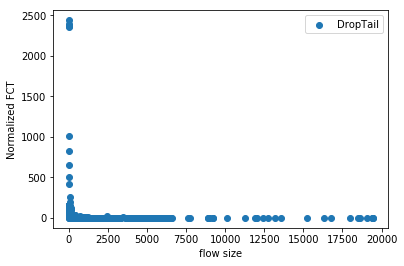

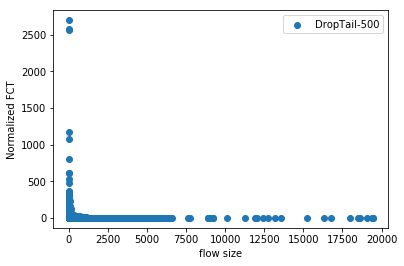

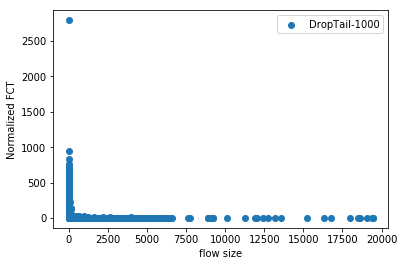

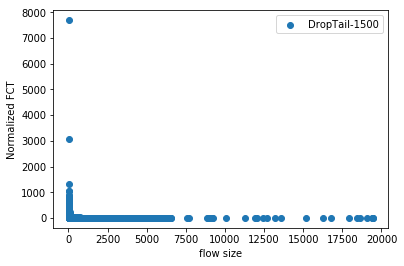

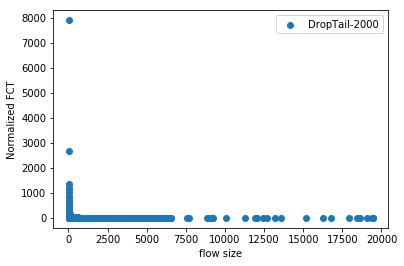

In [28]:
if __name__ == '__main__':
    FCT_analysis = FCT("/home/ovs2/lining/Gearbox/automatic/", "Topology-incast-singlenode.tcl",\
                   1000, \
                   [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                   # ["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000",\
                   ["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"])
    # Byte
    flow_size=[0, 6, 13, 19, 33, 53, 133, 1333, 3333, 6667, float('inf')]
    print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    #algs=["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000"]
    #algs=["HRCC", "AFQ1000", "AFQ100"]
    algs=["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"]
    # when scale = [0,0], there is no adjust to the graph
    scale=[150,100]
    scale=[0,0]
    for load in [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95]:
        FCT_analysis.plot_FCT_percentile_fix_load(algs, load, .95, flow_size, scale)

    FCT_analysis.plotting_mean_FCT()

    for alg in algs:
        FCT_analysis.plot_FCT_flowsize(alg, 0.5, label=alg, scale=[0, 0])